<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Exams/finals/NGupta_question2_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
from typing import List, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub

In [3]:
tf.__version__

'2.3.0'

# Get Data

In [4]:
!rm -rf ./*

In [5]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2020-08-08 00:51:48--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  77.0MB/s    in 1.0s    

2020-08-08 00:51:49 (77.0 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [6]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data = data[[5, 0]]
data.head()

,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
data = data.rename(columns={5:'text', 0:'sentiment'})
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Prepare Labels

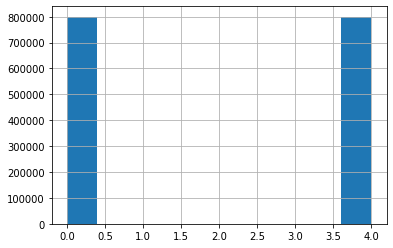

In [11]:
data['sentiment'].hist()

In [12]:
data['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [13]:
data.loc[data['sentiment'] == 4, 'sentiment'] = 1

In [14]:
data['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [15]:
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Shuffle Data

In [16]:
data = data.sample(frac=1).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Max Sequence Length

The number of characters reaches a max length of 374, but that might be an exception. For Universal Sentence Encoder (USE), we can possibly limit this to a smaller number based on the histogram of character lengths. 

The number of words reaches a maximum value of 64. For RNN variants, again, we can limit this to a smaller number based on the distribution of the number of words as shown below

In [17]:
data['charlen'] = data['text'].str.len()
data['wordlen'] = data['text'].str.split().str.len()
data.head()

,text,sentiment,charlen,wordlen
0,@funnyclub hey there is loads to the ebook hey...,1,79,16
1,@Wolfgang_ Yea Gotta wait for this work day t...,0,57,11
2,Woke up drowning in mucus. Much more of this a...,0,85,19
3,@Emmasboredom yeah i'm sorry is it the doodle...,0,51,9
4,Also wishing @andybudd et. al. a great #uxlondon,1,49,8


In [18]:
print('Maximum review length (words): {}'.format(data['wordlen'].max()))
print('Minimum review length (words): {}'.format(data['wordlen'].min()))
print('Maximum review length (chars): {}'.format(data['charlen'].max()))
print('Minimum review length (chars): {}'.format(data['charlen'].min()))


Maximum review length (words): 64
Minimum review length (words): 1
Maximum review length (chars): 374
Minimum review length (chars): 6


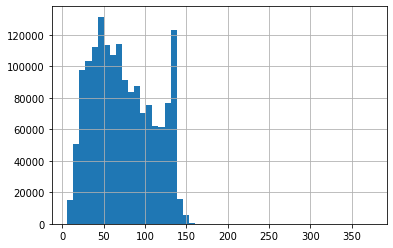

In [19]:
data['charlen'].hist(bins=50)

In [20]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_USE = int(np.quantile(data['charlen'],0.975))
time_steps_USE

138

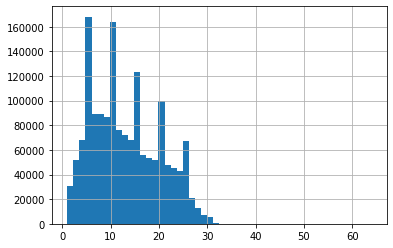

In [21]:
data['wordlen'].hist(bins=50)

In [22]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_RNN = int(np.quantile(data['wordlen'],0.975))
time_steps_RNN

27

# Train and Validation Split

In [23]:
msk = np.random.rand(len(data)) < 0.5
train_data = data[msk]
val_data = data[~msk]

In [24]:
# Create datasets (limit to max time step for USE)
train_text = train_data['text'].tolist()
train_text = [' '.join(t.split()[0:time_steps_USE]) for t in train_text]
train_text = [' '.join(t.split()) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_data['sentiment']

val_text = val_data['text'].tolist()
val_text = [' '.join(t.split()[0:time_steps_USE]) for t in val_text]
val_text = [' '.join(t.split()) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = val_data['sentiment']

In [25]:
print(len(train_text), len(train_label))
print(len(val_text), len(val_label))

799789 799789
800211 800211


In [26]:
# Checking split --> both test and train contain roughly the same % of observation from each class
print(sum(train_label == 0)/len(train_label), sum(val_label == 0)/len(val_label))
print(sum(train_label == 1)/len(train_label), sum(val_label == 1)/len(val_label))

0.500552020595432 0.4994482705186507
0.499447979404568 0.5005517294813493


# Training

In [27]:
def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [28]:
train_text[0].shape

(1,)

In [29]:
set(train_label)

{0, 1}

In [30]:
num_classes = len(set(train_label))
num_classes

2

In [31]:
USE = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

In [32]:
# This is useful to debug the issues with input shape: https://github.com/tensorflow/hub/issues/526
input_text = Input(shape=(), name='sent1',dtype=tf.string)
embedding = USE(input_text)
# dense1 = Dense(256, activation='relu')(embedding)
# dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(100, activation='relu')(dropout1)
dense2 = Dense(100, activation='relu')(embedding)
dropout2 = Dropout(0.2)(dense2)
pred = Dense(num_classes, activation='softmax')(dropout2)
model = Model(inputs=[input_text], outputs=pred)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent1 (InputLayer)           [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 256,849,326
Trainable params: 51,502
Non-trainable params: 256,797,824
_________________________________________________________________


In [33]:
model.predict(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

array([[0.49767357, 0.5023264 ],
       [0.5003005 , 0.4996995 ]], dtype=float32)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=3)

from tensorflow.keras.callbacks import ModelCheckpoint
# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=True, save_weights_only=False, 
    mode='auto', save_frequency=1
    )

In [35]:
BATCH_SIZE = 1024
EPOCHS = 10
history = model.fit(
    tf.convert_to_tensor(train_text), train_label,
    validation_data=(val_text, val_label),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[es] # , checkpoint]    
    )

Epoch 1/10
782/782 [==============================] - 103s 132ms/step - loss: 0.4655 - accuracy: 0.7792 - val_loss: 0.4451 - val_accuracy: 0.7899
Epoch 2/10
782/782 [==============================] - 99s 126ms/step - loss: 0.4407 - accuracy: 0.7932 - val_loss: 0.4342 - val_accuracy: 0.7964
Epoch 3/10
782/782 [==============================] - 99s 127ms/step - loss: 0.4338 - accuracy: 0.7973 - val_loss: 0.4303 - val_accuracy: 0.7983
Epoch 4/10
782/782 [==============================] - 98s 126ms/step - loss: 0.4297 - accuracy: 0.7999 - val_loss: 0.4276 - val_accuracy: 0.8000
Epoch 5/10
782/782 [==============================] - 97s 124ms/step - loss: 0.4269 - accuracy: 0.8013 - val_loss: 0.4262 - val_accuracy: 0.8009
Epoch 6/10
782/782 [==============================] - 97s 124ms/step - loss: 0.4249 - accuracy: 0.8032 - val_loss: 0.4255 - val_accuracy: 0.8016
Epoch 7/10
782/782 [==============================] - 97s 124ms/step - loss: 0.4230 - accuracy: 0.8040 - val_loss: 0.4245 - val_a

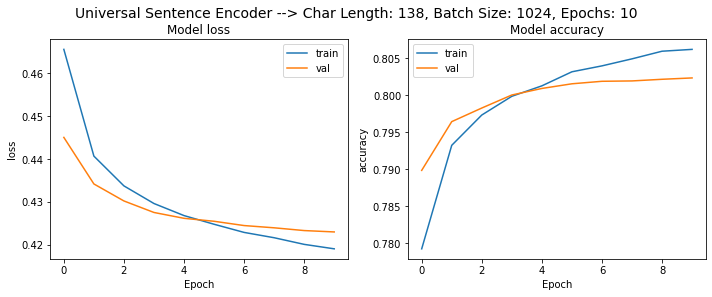

In [36]:
plot_metrics(
    history,
    metrics=['loss', 'accuracy'],
    title = f"Universal Sentence Encoder --> Char Length: {time_steps_USE}, Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}")

# Predictions

In [37]:
predictions = model.predict(val_text)
predictions[:5]

array([[0.01431939, 0.9856806 ],
       [0.9803152 , 0.01968481],
       [0.9454794 , 0.05452059],
       [0.29920438, 0.7007956 ],
       [0.00537598, 0.994624  ]], dtype=float32)

In [38]:
predictions_max = tf.math.argmax(predictions, axis=1)
predictions_max[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 1, 1])>

In [39]:
val_label[0:5]

0    1
1    0
2    0
3    0
4    1
Name: sentiment, dtype: int64

In [40]:
m = tf.keras.metrics.Accuracy()
m.update_state(val_label, predictions_max)
m.result().numpy()

0.80235213

In [41]:
predictions

array([[0.01431939, 0.9856806 ],
       [0.9803152 , 0.01968481],
       [0.9454794 , 0.05452059],
       ...,
       [0.40173218, 0.5982678 ],
       [0.9896987 , 0.01030126],
       [0.362221  , 0.637779  ]], dtype=float32)